## Graphs of CPU load tests
This notebook creates the graphs of perf data collected with tool test_CPU_parallel.py  
See also: https://github.com/LucaCanali/Miscellaneous/tree/master/Perf_Testing  
Performance data is for testing servers of the types: RAC52, RAC54 and RAC55.  

We don't report the exact CPU model in this doc.
We omit the configuration of networking and I/O, as not relevant for these tests.  
The servers were all installed with the same OS version: RHEL 7.9.  
Systems:  
---

**RAC52:**
 - 20 physical cores (2 sockets, 10 physical cores each), 40 logical cores visible on the OS due to hyperthreading
 - CPU max freq: 2.20 GHz
 - CPU from 2016
 - L1 caches: 32K + 32K, L2 cache 256K, L3 cache 25600K
 - RAM: DDR4, 512 GB
 
**RAC54:**
 - 8 physical cores (2 sockets, 4 physical cores each), 16 logical cores visible on the OS due to hyperthreading
 - CPU max freq: 3.80 GHz
 - CPU from 2019
 - L1 caches: 32K + 32K, L2 cache 1024K, L3 cache 16896K
 - RAM: DDR4, 768 GB
 
**RAC55:**
 - 16 physical cores (2 sockets, 8 physical cores each), 32 logical cores visible on the OS due to hyperthreading
 - CPU max freq: 4.2 GHz
 - CPU from 2019
 - L1 caches: 32K + 32K, L2 cache 512K, L3 cache 32768K
 - RAM: DDR4, 1 TB
 

In [1]:
# This notebook uses pandas to read and process Data in csv format
import pandas as pd

In [2]:
# Path to the data
# Data comes from the output of the tool test_CPU_parallel.py
# See https://github.com/LucaCanali/Miscellaneous/tree/master/Perf_Testing
PATH = "../Data/"

In [3]:
data = []
data.append({'key': 'RAC52', 'val': pd.read_csv(PATH + "test_CPU_parallel_RAC52.csv")})
data.append({'key': 'RAC54', 'val': pd.read_csv(PATH + "test_CPU_parallel_RAC54.csv")})
data.append({'key': 'RAC55', 'val': pd.read_csv(PATH + "test_CPU_parallel_RAC55.csv")})

In [4]:
data[0].get('val').head()

,Num_concurrent_jobs,job_median_run_time (sec),job_mean_run_time (sec),job_stdev_run_time (sec)
0,1,41.60,41.78,0.35
1,2,41.50,41.54,0.56
2,3,44.34,43.48,1.62
3,4,43.00,42.89,1.05
4,5,44.55,44.48,1.30


In [5]:
data[0].get('val').columns

Index(['Num_concurrent_jobs', 'job_median_run_time (sec)',
       'job_mean_run_time (sec)', 'job_stdev_run_time (sec)'],
      dtype='object')

In [6]:
# Common code for Graphs setup and configuration

import matplotlib.pyplot as plt
plt.clf()
plt.style.use('default')

width = 12
height = 5

node_config = {1: {'name': 'RAC52', 'linestyle': 'solid', 'color': 'black', 'alpha': 1.0, 'linewidth': 3}, 
               2: {'name': 'RAC54', 'linestyle': 'solid', 'color': 'red', 'alpha': 1.0, 'linewidth': 3}, 
               3: {'name': 'RAC55', 'linestyle': 'solid', 'color': 'blue', 'alpha': 1.0, 'linewidth': 3} 
              }


<Figure size 640x480 with 0 Axes>

### Plot job duration as a function of number of concurrent workers
This is the raw data from the load generator 

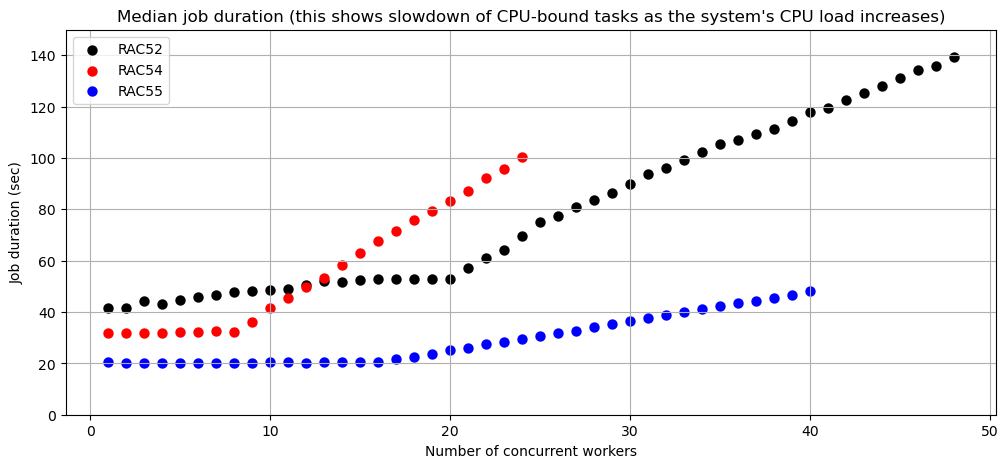

In [9]:
# Job duration
fig, ax = plt.subplots(figsize=(width, height))

for i, measurement in enumerate(data):
    df = measurement.get('val')
    instance = i + 1
    df.plot(kind='scatter', x='Num_concurrent_jobs', y='job_median_run_time (sec)', ax=ax, 
               linestyle=node_config[instance]['linestyle'],
               color=node_config[instance]['color'],
               alpha=node_config[instance]['alpha'],
               linewidth=node_config[instance]['linewidth'],
               label=node_config[instance]['name'])

ax.set_title("Median job duration (this shows slowdown of CPU-bound tasks as the system's CPU load increases)")
ax.set_ylim([0, 150])
ax.set_xlabel('Number of concurrent workers')
ax.set_ylabel('Job duration (sec)')

ax.grid()
plt.show()

### Plot numer of jobs executed per worker and per minute as a function of number of concurrent workers
This is computed data from the job duration dataset (first plot in this notebook)

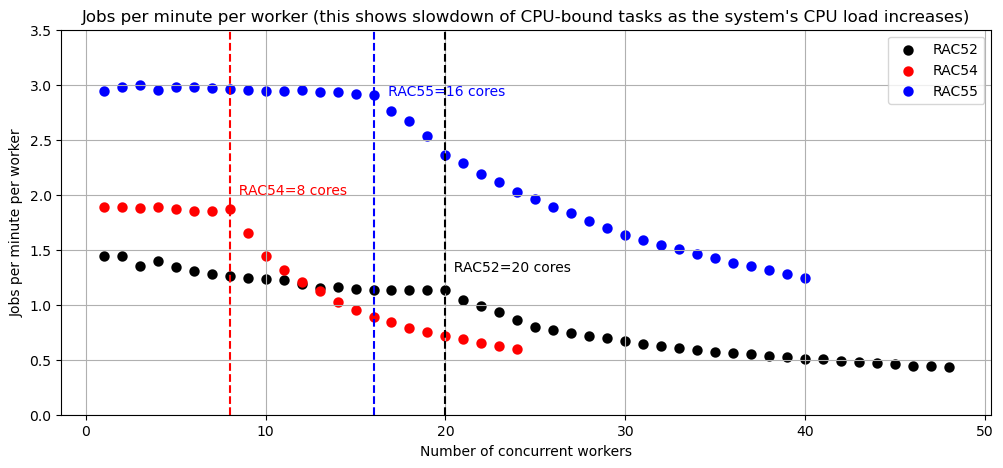

In [12]:
# Job executed per minute per worker
fig, ax = plt.subplots(figsize=(width, height))

for i, measurement in enumerate(data):
    df = measurement.get('val')
    instance = i + 1
    base = df['job_median_run_time (sec)'][0]
    df['jobs_per_minute'] = 60 / df['job_median_run_time (sec)']
    df.plot(kind='scatter', x='Num_concurrent_jobs', y='jobs_per_minute', ax=ax, 
               linestyle=node_config[instance]['linestyle'],
               color=node_config[instance]['color'],
               alpha=node_config[instance]['alpha'],
               linewidth=node_config[instance]['linewidth'],
               label=node_config[instance]['name'])

ax.set_title("Jobs per minute per worker (this shows slowdown of CPU-bound tasks as the system's CPU load increases)")
ax.set_ylim([0, 3.5])
ax.set_xlabel('Number of concurrent workers')
ax.set_ylabel('Jobs per minute per worker')

plt.text(8.0, 2.0, '  RAC54=8 cores', color='red')
ax.axvline(8.0, linestyle='--', color='red')

plt.text(16.1, 2.9, '   RAC55=16 cores', color='blue')
ax.axvline(16.0, linestyle='--', color='blue')

plt.text(20.0, 1.3, '  RAC52=20 cores', color='black')
ax.axvline(20.0, linestyle='--', color='black')

ax.grid()

plt.show()

### Plot numer of jobs executed in total per minute as a function of number of concurrent workers
This is computed data from the job duration dataset (first plot in this notebook)

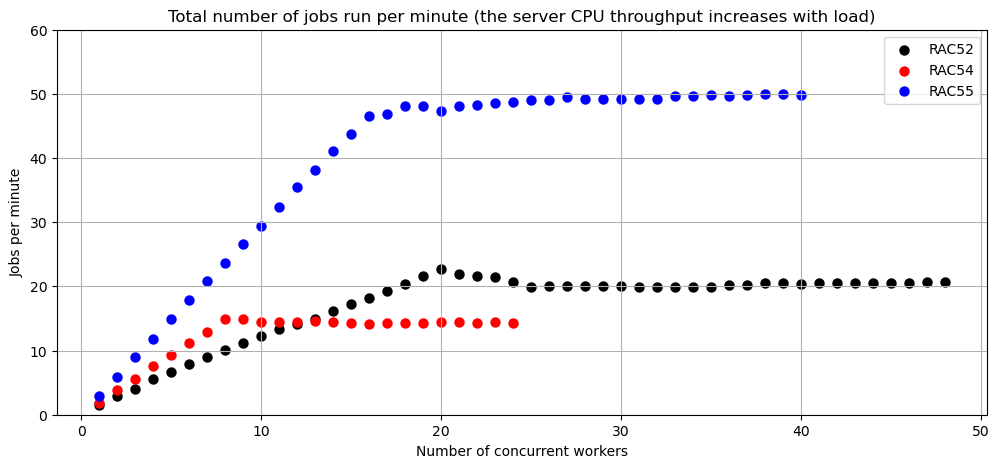

In [14]:
# Job executed in total per minute 

fig, ax = plt.subplots(figsize=(width, height))

for i, measurement in enumerate(data):
    df = measurement.get('val')
    instance = i + 1
    base = df['job_median_run_time (sec)'][0]
    df['jobs_per_minute'] = 60*  df['Num_concurrent_jobs'] / df['job_median_run_time (sec)']
    df.plot(kind='scatter', x='Num_concurrent_jobs', y='jobs_per_minute', ax=ax, 
               linestyle=node_config[instance]['linestyle'],
               color=node_config[instance]['color'],
               alpha=node_config[instance]['alpha'],
               linewidth=node_config[instance]['linewidth'],
               label=node_config[instance]['name'])

ax.set_title('Total number of jobs run per minute (the server CPU throughput increases with load)')
ax.set_ylim([0, 60])
ax.set_xlabel('Number of concurrent workers')
ax.set_ylabel('Jobs per minute')

ax.grid()

plt.show()

### Plot the job speedup as a function of number of concurrent workers
This is computed data from the job duration dataset (first plot in this notebook)  
Speedup and function of n (concurrent workers) is define as:  
Speedup(n) = Run_time(n=1) / Run_time(n)

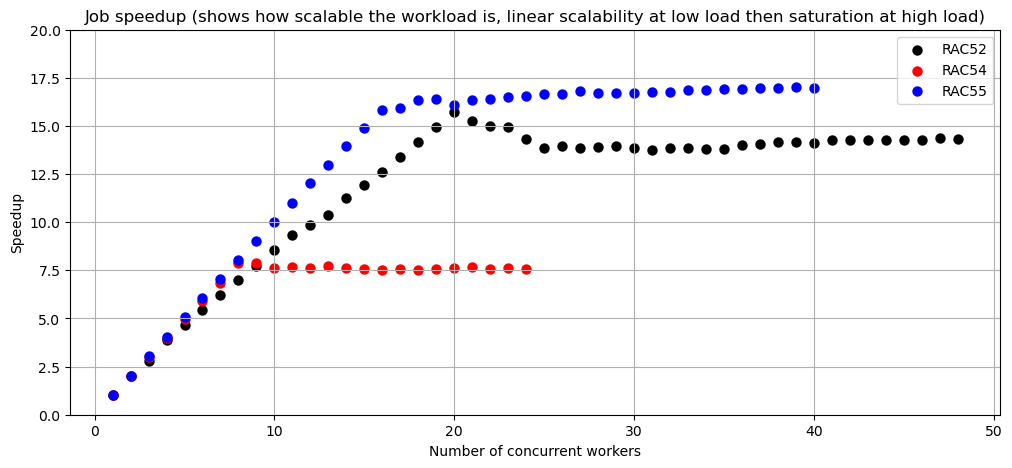

In [16]:
# Speedup
fig, ax = plt.subplots(figsize=(width, height))

for i, measurement in enumerate(data):
    df = measurement.get('val')
    instance = i + 1
    base = df['job_median_run_time (sec)'][0]
    df['speedup'] = df['Num_concurrent_jobs'] * base / df['job_median_run_time (sec)']
    df.plot(kind='scatter', x='Num_concurrent_jobs', y='speedup', ax=ax, 
               linestyle=node_config[instance]['linestyle'],
               color=node_config[instance]['color'],
               alpha=node_config[instance]['alpha'],
               linewidth=node_config[instance]['linewidth'],
               label=node_config[instance]['name'])

ax.set_title('Job speedup (shows how scalable the workload is, linear scalability at low load then saturation at high load)')
ax.set_ylim([0, 20])
ax.set_xlabel('Number of concurrent workers')
ax.set_ylabel('Speedup')

ax.grid()

plt.show()